# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

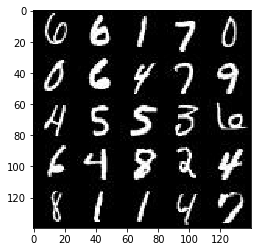

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

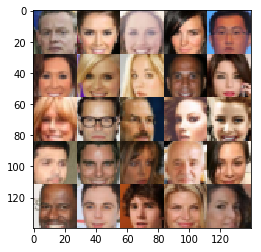

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                 name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='lrate')
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Not sure why it produces an error, it work fine while working on it, on my local machine!!!!
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.01

        first_conv = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        # apply leaky realu
        first_conv = tf.maximum(alpha*first_conv, first_conv)
        first_conv = tf.nn.dropout(first_conv, 0.9)

        second_conv = tf.layers.conv2d(first_conv, 128, 5, strides=2, padding='SAME')
        second_conv = tf.layers.batch_normalization(second_conv, training=True)
        second_conv = tf.maximum(alpha*second_conv, second_conv)
        first_conv = tf.nn.dropout(second_conv, 0.9)

        third_conv = tf.layers.conv2d(second_conv, 256, 5, strides=2, padding='SAME')
        third_conv = tf.layers.batch_normalization(third_conv, training=True)
        third_conv = tf.maximum(alpha * third_conv, third_conv)
        third_conv = tf.nn.dropout(third_conv, 0.9)

        flattened = tf.reshape(third_conv, (-1, 256* 4 * 4))
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.01
        conv_first = tf.layers.dense(z, 7*7*256)
        conv_first = tf.reshape(conv_first, (-1, 7, 7, 256))
        conv_first = tf.layers.batch_normalization(conv_first, training=is_train)
        conv_first = tf.maximum(alpha*conv_first, conv_first)
        
        conv_second = tf.layers.conv2d_transpose(conv_first, 128, 5, strides=2, padding='SAME')
        conv_second = tf.layers.batch_normalization(conv_second, training=is_train)
        conv_second = tf.maximum(alpha*conv_second, conv_second)
        
        conv_third = tf.layers.conv2d_transpose(conv_second, 64, 5, strides=2, padding='SAME')
        conv_third = tf.layers.batch_normalization(conv_third, training=is_train)
        conv_third = tf.maximum(alpha*conv_third, conv_third)
        
        conv_fourth = tf.layers.conv2d_transpose(conv_third, 64, 5, strides=2, padding='SAME')
        conv_fourth = tf.layers.batch_normalization(conv_fourth, training=is_train)
        conv_fourth = tf.maximum(alpha*conv_fourth, conv_fourth)
        
        logits = tf.layers.conv2d_transpose(conv_third, out_channel_dim, 5, strides=1, padding='SAME')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
#     print(type(learning_rate))
    how_many, width, height, depth = data_shape
    
    inputs_real, inputs_z, lrate = model_inputs(width, height, depth, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples = []
    # Count the steps zero-based, like hackerz do :)
    steps = 0
    print_every = 20
    show_every = 100
    losses = []
    
    saver = tf.train.Saver()

    
    # Based on the DCGAN.ipynb videos:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                # TODO: Train Model
                noise = np.random.uniform(-1, 1, size=(batch_size, z_dim))
#                 print(noise)
#                 print(batch_images)

                # Run optimizers
                sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: noise, lrate: learning_rate})
                sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: noise, lrate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: noise, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: noise})

                    print("Training epoch {} of {} has: ".format(epoch, epoch_count),
                          "Discriminator loss of {:.4f}".format(train_loss_d),
                          "and generator loss of {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, depth, data_image_mode)

                saver.save(sess, './checkpoints/generator.ckpt')
                
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Training epoch 0 of 2 has:  Discriminator loss of 0.5005 and generator loss of 5.4409
Training epoch 0 of 2 has:  Discriminator loss of 0.8347 and generator loss of 1.9283
Training epoch 0 of 2 has:  Discriminator loss of 0.6854 and generator loss of 1.6225
Training epoch 0 of 2 has:  Discriminator loss of 2.5323 and generator loss of 0.1931
Training epoch 0 of 2 has:  Discriminator loss of 2.3218 and generator loss of 0.2159


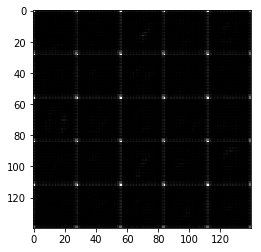

Training epoch 0 of 2 has:  Discriminator loss of 1.6272 and generator loss of 0.3576
Training epoch 0 of 2 has:  Discriminator loss of 1.9355 and generator loss of 0.2701
Training epoch 0 of 2 has:  Discriminator loss of 1.4498 and generator loss of 1.0841
Training epoch 0 of 2 has:  Discriminator loss of 1.2736 and generator loss of 1.0186
Training epoch 0 of 2 has:  Discriminator loss of 1.3807 and generator loss of 1.3199


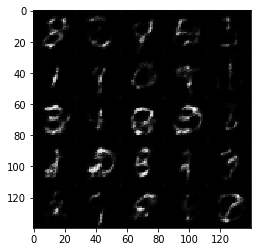

Training epoch 0 of 2 has:  Discriminator loss of 1.4114 and generator loss of 1.3392
Training epoch 0 of 2 has:  Discriminator loss of 1.3121 and generator loss of 0.8728
Training epoch 0 of 2 has:  Discriminator loss of 2.1661 and generator loss of 0.2753
Training epoch 0 of 2 has:  Discriminator loss of 1.3564 and generator loss of 0.8587
Training epoch 0 of 2 has:  Discriminator loss of 1.5884 and generator loss of 1.6998


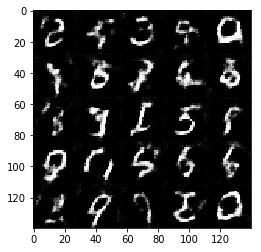

Training epoch 0 of 2 has:  Discriminator loss of 1.7865 and generator loss of 0.3207
Training epoch 0 of 2 has:  Discriminator loss of 1.8664 and generator loss of 0.2878
Training epoch 0 of 2 has:  Discriminator loss of 1.1521 and generator loss of 1.3702
Training epoch 0 of 2 has:  Discriminator loss of 1.2502 and generator loss of 0.8244
Training epoch 0 of 2 has:  Discriminator loss of 1.5181 and generator loss of 0.4676


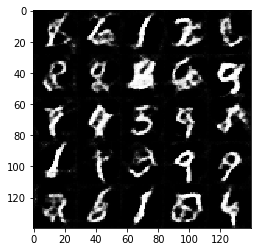

Training epoch 0 of 2 has:  Discriminator loss of 1.2860 and generator loss of 1.4035
Training epoch 0 of 2 has:  Discriminator loss of 1.8395 and generator loss of 0.3007
Training epoch 0 of 2 has:  Discriminator loss of 1.2543 and generator loss of 0.9122
Training epoch 0 of 2 has:  Discriminator loss of 1.3089 and generator loss of 0.6001
Training epoch 0 of 2 has:  Discriminator loss of 1.6701 and generator loss of 1.6638


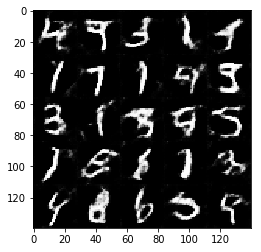

Training epoch 0 of 2 has:  Discriminator loss of 1.6226 and generator loss of 0.3719
Training epoch 0 of 2 has:  Discriminator loss of 2.1017 and generator loss of 0.2380
Training epoch 0 of 2 has:  Discriminator loss of 0.9047 and generator loss of 1.4422
Training epoch 0 of 2 has:  Discriminator loss of 1.5342 and generator loss of 0.5206
Training epoch 0 of 2 has:  Discriminator loss of 1.2404 and generator loss of 0.7563


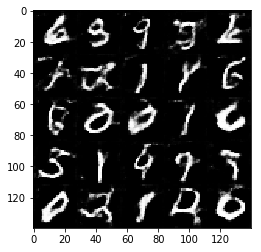

Training epoch 0 of 2 has:  Discriminator loss of 1.6993 and generator loss of 0.4233
Training epoch 0 of 2 has:  Discriminator loss of 1.3278 and generator loss of 0.5505
Training epoch 0 of 2 has:  Discriminator loss of 1.2780 and generator loss of 1.0181
Training epoch 0 of 2 has:  Discriminator loss of 1.1244 and generator loss of 1.4949
Training epoch 0 of 2 has:  Discriminator loss of 1.0432 and generator loss of 1.1466


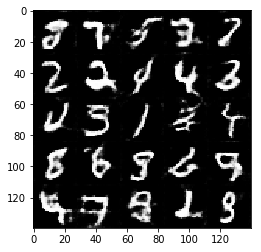

Training epoch 0 of 2 has:  Discriminator loss of 1.5146 and generator loss of 0.4819
Training epoch 0 of 2 has:  Discriminator loss of 1.3296 and generator loss of 1.3387
Training epoch 0 of 2 has:  Discriminator loss of 1.1648 and generator loss of 0.8956
Training epoch 0 of 2 has:  Discriminator loss of 1.0842 and generator loss of 1.6429
Training epoch 0 of 2 has:  Discriminator loss of 1.3369 and generator loss of 0.7262


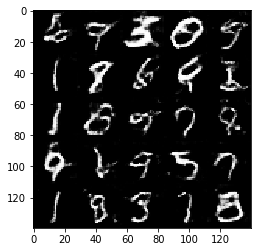

Training epoch 0 of 2 has:  Discriminator loss of 1.1616 and generator loss of 0.7983
Training epoch 0 of 2 has:  Discriminator loss of 1.2143 and generator loss of 0.8980
Training epoch 0 of 2 has:  Discriminator loss of 1.3780 and generator loss of 0.5309
Training epoch 0 of 2 has:  Discriminator loss of 1.1859 and generator loss of 1.1580
Training epoch 0 of 2 has:  Discriminator loss of 1.2604 and generator loss of 0.9067


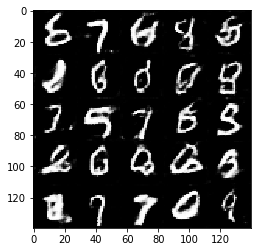

Training epoch 0 of 2 has:  Discriminator loss of 1.0535 and generator loss of 1.6657
Training epoch 0 of 2 has:  Discriminator loss of 1.6545 and generator loss of 0.3689
Training epoch 0 of 2 has:  Discriminator loss of 0.9982 and generator loss of 1.1967
Training epoch 0 of 2 has:  Discriminator loss of 1.1182 and generator loss of 0.8183
Training epoch 0 of 2 has:  Discriminator loss of 1.5137 and generator loss of 0.4573


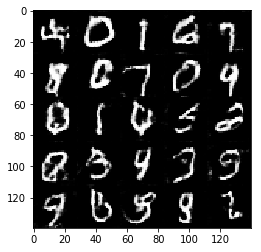

Training epoch 0 of 2 has:  Discriminator loss of 1.1487 and generator loss of 1.3226
Training epoch 0 of 2 has:  Discriminator loss of 1.6225 and generator loss of 0.3654
Training epoch 0 of 2 has:  Discriminator loss of 2.1332 and generator loss of 0.2652
Training epoch 0 of 2 has:  Discriminator loss of 1.4729 and generator loss of 0.5268
Training epoch 0 of 2 has:  Discriminator loss of 1.5912 and generator loss of 0.4157


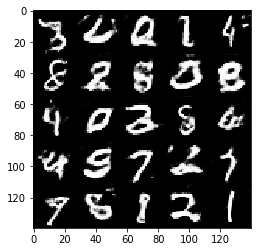

Training epoch 0 of 2 has:  Discriminator loss of 1.6171 and generator loss of 0.4120
Training epoch 0 of 2 has:  Discriminator loss of 1.3763 and generator loss of 0.6803
Training epoch 0 of 2 has:  Discriminator loss of 1.4005 and generator loss of 1.5149
Training epoch 0 of 2 has:  Discriminator loss of 1.0611 and generator loss of 1.6630
Training epoch 0 of 2 has:  Discriminator loss of 1.0507 and generator loss of 1.8312


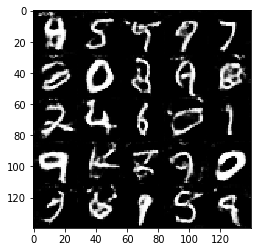

Training epoch 0 of 2 has:  Discriminator loss of 1.4211 and generator loss of 0.4766
Training epoch 0 of 2 has:  Discriminator loss of 1.2307 and generator loss of 1.7705
Training epoch 0 of 2 has:  Discriminator loss of 1.3541 and generator loss of 0.6858
Training epoch 0 of 2 has:  Discriminator loss of 1.2759 and generator loss of 0.6398
Training epoch 0 of 2 has:  Discriminator loss of 1.0445 and generator loss of 0.9772


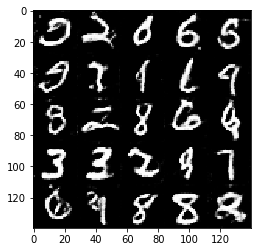

Training epoch 0 of 2 has:  Discriminator loss of 1.3979 and generator loss of 0.4804
Training epoch 0 of 2 has:  Discriminator loss of 1.6899 and generator loss of 0.4103
Training epoch 0 of 2 has:  Discriminator loss of 1.0028 and generator loss of 1.2103
Training epoch 0 of 2 has:  Discriminator loss of 1.0506 and generator loss of 1.2827
Training epoch 0 of 2 has:  Discriminator loss of 0.9330 and generator loss of 2.2179


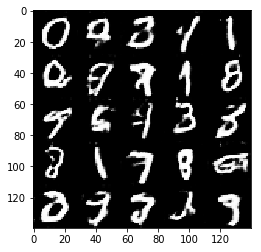

Training epoch 0 of 2 has:  Discriminator loss of 1.1488 and generator loss of 0.9138
Training epoch 0 of 2 has:  Discriminator loss of 1.3265 and generator loss of 0.5080
Training epoch 0 of 2 has:  Discriminator loss of 1.9261 and generator loss of 0.3304
Training epoch 0 of 2 has:  Discriminator loss of 1.1048 and generator loss of 0.9226
Training epoch 0 of 2 has:  Discriminator loss of 1.6265 and generator loss of 0.3906


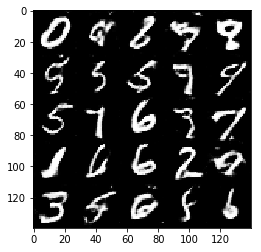

Training epoch 0 of 2 has:  Discriminator loss of 1.3503 and generator loss of 0.6642
Training epoch 0 of 2 has:  Discriminator loss of 1.4325 and generator loss of 0.5657
Training epoch 0 of 2 has:  Discriminator loss of 1.3074 and generator loss of 0.6458
Training epoch 0 of 2 has:  Discriminator loss of 1.3397 and generator loss of 0.5597
Training epoch 0 of 2 has:  Discriminator loss of 1.3207 and generator loss of 0.6234


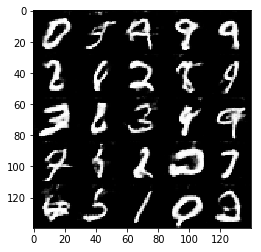

Training epoch 0 of 2 has:  Discriminator loss of 1.1624 and generator loss of 0.7122
Training epoch 0 of 2 has:  Discriminator loss of 1.2087 and generator loss of 2.0198
Training epoch 0 of 2 has:  Discriminator loss of 1.1044 and generator loss of 0.8144
Training epoch 0 of 2 has:  Discriminator loss of 1.2544 and generator loss of 0.6037
Training epoch 0 of 2 has:  Discriminator loss of 0.9191 and generator loss of 1.6350


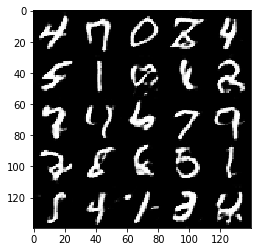

Training epoch 0 of 2 has:  Discriminator loss of 0.9368 and generator loss of 1.5202
Training epoch 0 of 2 has:  Discriminator loss of 1.0902 and generator loss of 1.5966
Training epoch 0 of 2 has:  Discriminator loss of 1.1773 and generator loss of 1.6666
Training epoch 0 of 2 has:  Discriminator loss of 1.8583 and generator loss of 0.3593
Training epoch 0 of 2 has:  Discriminator loss of 1.1138 and generator loss of 0.6676


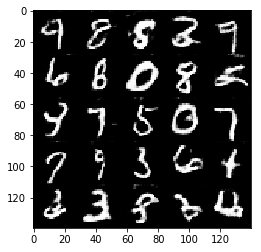

Training epoch 0 of 2 has:  Discriminator loss of 1.1017 and generator loss of 1.5602
Training epoch 0 of 2 has:  Discriminator loss of 1.6296 and generator loss of 0.3993
Training epoch 0 of 2 has:  Discriminator loss of 1.1757 and generator loss of 0.7787
Training epoch 1 of 2 has:  Discriminator loss of 1.1614 and generator loss of 1.4036
Training epoch 1 of 2 has:  Discriminator loss of 1.3008 and generator loss of 0.8175


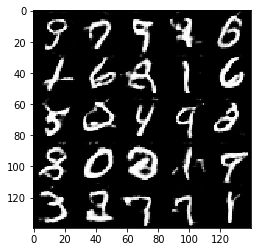

Training epoch 1 of 2 has:  Discriminator loss of 2.1383 and generator loss of 0.2229
Training epoch 1 of 2 has:  Discriminator loss of 1.1731 and generator loss of 0.7261
Training epoch 1 of 2 has:  Discriminator loss of 1.0285 and generator loss of 1.2323
Training epoch 1 of 2 has:  Discriminator loss of 1.0258 and generator loss of 0.8994
Training epoch 1 of 2 has:  Discriminator loss of 1.3718 and generator loss of 0.5315


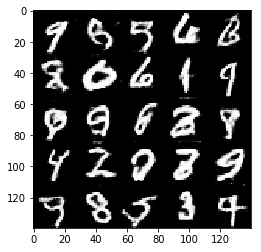

Training epoch 1 of 2 has:  Discriminator loss of 1.0456 and generator loss of 1.0978
Training epoch 1 of 2 has:  Discriminator loss of 1.4989 and generator loss of 0.5423
Training epoch 1 of 2 has:  Discriminator loss of 2.1308 and generator loss of 0.2549
Training epoch 1 of 2 has:  Discriminator loss of 1.2556 and generator loss of 0.5659
Training epoch 1 of 2 has:  Discriminator loss of 1.1031 and generator loss of 0.9523


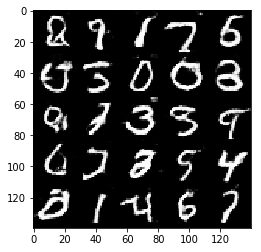

Training epoch 1 of 2 has:  Discriminator loss of 0.9342 and generator loss of 1.2027
Training epoch 1 of 2 has:  Discriminator loss of 1.6597 and generator loss of 0.4498
Training epoch 1 of 2 has:  Discriminator loss of 1.8371 and generator loss of 0.4194
Training epoch 1 of 2 has:  Discriminator loss of 1.3453 and generator loss of 0.5587
Training epoch 1 of 2 has:  Discriminator loss of 1.4382 and generator loss of 0.6345


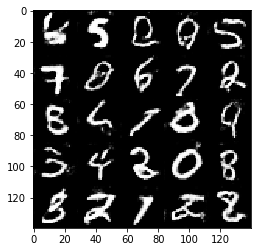

Training epoch 1 of 2 has:  Discriminator loss of 1.6876 and generator loss of 0.4615
Training epoch 1 of 2 has:  Discriminator loss of 1.6318 and generator loss of 0.4421
Training epoch 1 of 2 has:  Discriminator loss of 1.3671 and generator loss of 0.4797
Training epoch 1 of 2 has:  Discriminator loss of 1.3269 and generator loss of 0.9043
Training epoch 1 of 2 has:  Discriminator loss of 1.2669 and generator loss of 1.8261


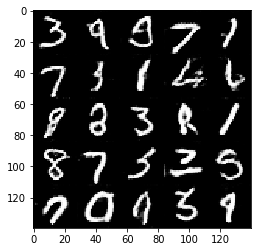

Training epoch 1 of 2 has:  Discriminator loss of 1.7849 and generator loss of 0.3302
Training epoch 1 of 2 has:  Discriminator loss of 1.1459 and generator loss of 0.8138
Training epoch 1 of 2 has:  Discriminator loss of 1.0534 and generator loss of 1.6016
Training epoch 1 of 2 has:  Discriminator loss of 1.4081 and generator loss of 2.4460
Training epoch 1 of 2 has:  Discriminator loss of 1.4072 and generator loss of 0.6274


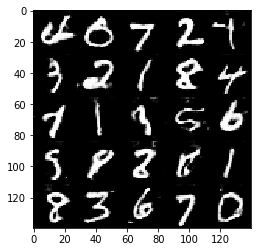

Training epoch 1 of 2 has:  Discriminator loss of 1.3640 and generator loss of 0.6691
Training epoch 1 of 2 has:  Discriminator loss of 1.0690 and generator loss of 1.2391
Training epoch 1 of 2 has:  Discriminator loss of 1.0759 and generator loss of 1.8266
Training epoch 1 of 2 has:  Discriminator loss of 1.2355 and generator loss of 0.6347
Training epoch 1 of 2 has:  Discriminator loss of 0.8989 and generator loss of 1.1005


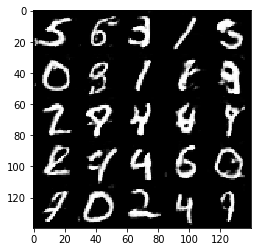

Training epoch 1 of 2 has:  Discriminator loss of 1.1724 and generator loss of 0.8372
Training epoch 1 of 2 has:  Discriminator loss of 1.7749 and generator loss of 0.3818
Training epoch 1 of 2 has:  Discriminator loss of 1.8381 and generator loss of 0.3823
Training epoch 1 of 2 has:  Discriminator loss of 1.7782 and generator loss of 0.3366
Training epoch 1 of 2 has:  Discriminator loss of 1.0069 and generator loss of 1.3330


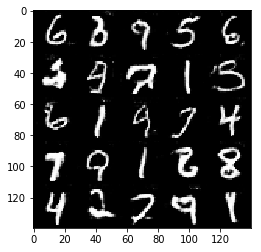

Training epoch 1 of 2 has:  Discriminator loss of 1.5482 and generator loss of 0.5354
Training epoch 1 of 2 has:  Discriminator loss of 0.9214 and generator loss of 1.2498
Training epoch 1 of 2 has:  Discriminator loss of 1.1240 and generator loss of 1.8313
Training epoch 1 of 2 has:  Discriminator loss of 1.1346 and generator loss of 1.7738
Training epoch 1 of 2 has:  Discriminator loss of 1.9294 and generator loss of 0.3124


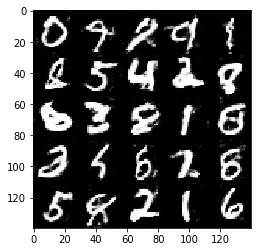

Training epoch 1 of 2 has:  Discriminator loss of 1.2094 and generator loss of 0.9069
Training epoch 1 of 2 has:  Discriminator loss of 1.1653 and generator loss of 2.1734
Training epoch 1 of 2 has:  Discriminator loss of 1.0442 and generator loss of 0.9462
Training epoch 1 of 2 has:  Discriminator loss of 0.8965 and generator loss of 1.5003
Training epoch 1 of 2 has:  Discriminator loss of 0.9458 and generator loss of 1.3679


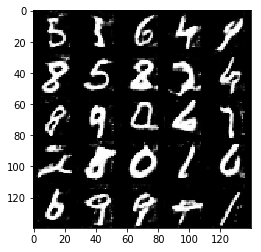

Training epoch 1 of 2 has:  Discriminator loss of 1.5568 and generator loss of 2.4417
Training epoch 1 of 2 has:  Discriminator loss of 1.0003 and generator loss of 1.2396
Training epoch 1 of 2 has:  Discriminator loss of 0.9620 and generator loss of 0.9973
Training epoch 1 of 2 has:  Discriminator loss of 1.0043 and generator loss of 1.2454
Training epoch 1 of 2 has:  Discriminator loss of 0.8751 and generator loss of 2.1244


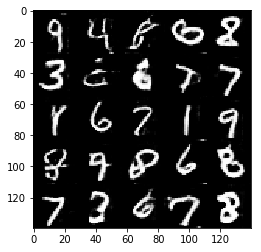

Training epoch 1 of 2 has:  Discriminator loss of 0.8724 and generator loss of 1.4428
Training epoch 1 of 2 has:  Discriminator loss of 1.1852 and generator loss of 0.8154
Training epoch 1 of 2 has:  Discriminator loss of 1.1493 and generator loss of 0.9477
Training epoch 1 of 2 has:  Discriminator loss of 0.9792 and generator loss of 1.1985
Training epoch 1 of 2 has:  Discriminator loss of 1.3450 and generator loss of 0.5724


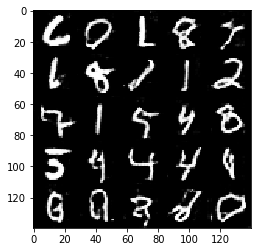

Training epoch 1 of 2 has:  Discriminator loss of 1.1084 and generator loss of 1.5674
Training epoch 1 of 2 has:  Discriminator loss of 1.2116 and generator loss of 2.1411
Training epoch 1 of 2 has:  Discriminator loss of 0.9814 and generator loss of 1.1360
Training epoch 1 of 2 has:  Discriminator loss of 1.0253 and generator loss of 1.0159
Training epoch 1 of 2 has:  Discriminator loss of 1.1640 and generator loss of 0.9987


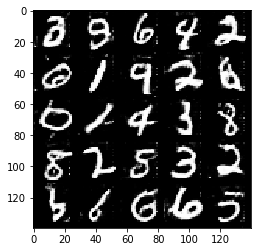

Training epoch 1 of 2 has:  Discriminator loss of 1.3223 and generator loss of 0.7134
Training epoch 1 of 2 has:  Discriminator loss of 1.2091 and generator loss of 0.7727
Training epoch 1 of 2 has:  Discriminator loss of 1.0161 and generator loss of 1.8022
Training epoch 1 of 2 has:  Discriminator loss of 1.2139 and generator loss of 0.7385
Training epoch 1 of 2 has:  Discriminator loss of 1.3112 and generator loss of 0.6934


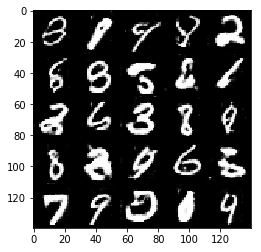

Training epoch 1 of 2 has:  Discriminator loss of 1.2891 and generator loss of 0.5603
Training epoch 1 of 2 has:  Discriminator loss of 0.9559 and generator loss of 1.0535
Training epoch 1 of 2 has:  Discriminator loss of 1.1961 and generator loss of 2.3056
Training epoch 1 of 2 has:  Discriminator loss of 1.2078 and generator loss of 2.1430
Training epoch 1 of 2 has:  Discriminator loss of 0.8792 and generator loss of 1.1722


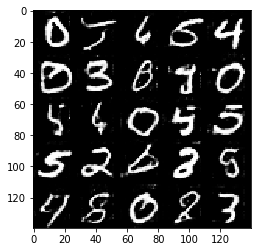

Training epoch 1 of 2 has:  Discriminator loss of 1.1410 and generator loss of 0.9304
Training epoch 1 of 2 has:  Discriminator loss of 1.1754 and generator loss of 0.9018
Training epoch 1 of 2 has:  Discriminator loss of 2.0032 and generator loss of 0.3197
Training epoch 1 of 2 has:  Discriminator loss of 0.9213 and generator loss of 1.4450
Training epoch 1 of 2 has:  Discriminator loss of 0.8945 and generator loss of 1.6423


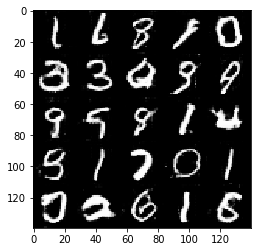

Training epoch 1 of 2 has:  Discriminator loss of 1.6076 and generator loss of 0.5559
Training epoch 1 of 2 has:  Discriminator loss of 1.0431 and generator loss of 1.6795
Training epoch 1 of 2 has:  Discriminator loss of 1.5485 and generator loss of 0.5292
Training epoch 1 of 2 has:  Discriminator loss of 0.9219 and generator loss of 1.0385
Training epoch 1 of 2 has:  Discriminator loss of 1.0536 and generator loss of 1.6974


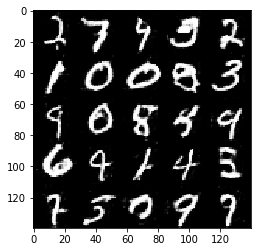

Training epoch 1 of 2 has:  Discriminator loss of 1.0965 and generator loss of 1.8796
Training epoch 1 of 2 has:  Discriminator loss of 1.0141 and generator loss of 0.9979
Training epoch 1 of 2 has:  Discriminator loss of 0.8375 and generator loss of 1.3533
Training epoch 1 of 2 has:  Discriminator loss of 1.1340 and generator loss of 2.5387
Training epoch 1 of 2 has:  Discriminator loss of 0.8238 and generator loss of 1.8399


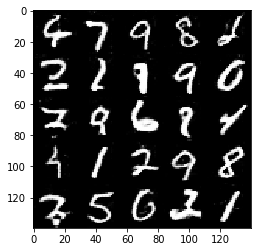

Training epoch 1 of 2 has:  Discriminator loss of 1.0486 and generator loss of 1.4630
Training epoch 1 of 2 has:  Discriminator loss of 1.1643 and generator loss of 1.0642
Training epoch 1 of 2 has:  Discriminator loss of 1.2381 and generator loss of 0.6959
Training epoch 1 of 2 has:  Discriminator loss of 0.8969 and generator loss of 2.1264
Training epoch 1 of 2 has:  Discriminator loss of 0.8881 and generator loss of 1.3731


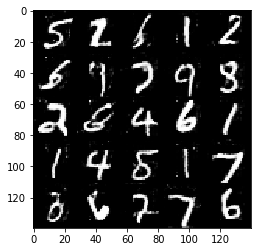

Training epoch 1 of 2 has:  Discriminator loss of 0.9023 and generator loss of 1.5398
Training epoch 1 of 2 has:  Discriminator loss of 1.0978 and generator loss of 0.8290


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0008
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Training epoch 0 of 1 has:  Discriminator loss of 0.6365 and generator loss of 1.7820
Training epoch 0 of 1 has:  Discriminator loss of 2.3056 and generator loss of 0.2639
Training epoch 0 of 1 has:  Discriminator loss of 0.9705 and generator loss of 0.9887
Training epoch 0 of 1 has:  Discriminator loss of 0.5861 and generator loss of 1.9005
Training epoch 0 of 1 has:  Discriminator loss of 1.1497 and generator loss of 1.2909


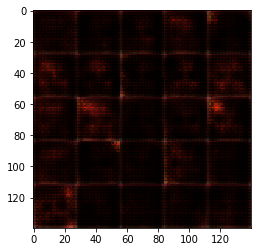

Training epoch 0 of 1 has:  Discriminator loss of 1.2459 and generator loss of 1.0606
Training epoch 0 of 1 has:  Discriminator loss of 1.3882 and generator loss of 0.4993
Training epoch 0 of 1 has:  Discriminator loss of 2.1452 and generator loss of 0.2005
Training epoch 0 of 1 has:  Discriminator loss of 1.2328 and generator loss of 0.6408
Training epoch 0 of 1 has:  Discriminator loss of 2.0421 and generator loss of 0.2734


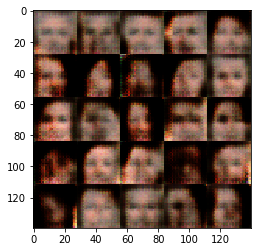

Training epoch 0 of 1 has:  Discriminator loss of 1.2068 and generator loss of 0.8502
Training epoch 0 of 1 has:  Discriminator loss of 2.2379 and generator loss of 0.1978
Training epoch 0 of 1 has:  Discriminator loss of 1.3679 and generator loss of 0.6206
Training epoch 0 of 1 has:  Discriminator loss of 1.2164 and generator loss of 0.9083
Training epoch 0 of 1 has:  Discriminator loss of 1.0629 and generator loss of 1.3945


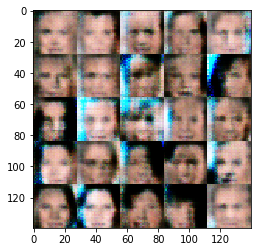

Training epoch 0 of 1 has:  Discriminator loss of 1.5559 and generator loss of 0.4952
Training epoch 0 of 1 has:  Discriminator loss of 2.0973 and generator loss of 0.2017
Training epoch 0 of 1 has:  Discriminator loss of 1.3518 and generator loss of 0.8669
Training epoch 0 of 1 has:  Discriminator loss of 1.3071 and generator loss of 0.6685
Training epoch 0 of 1 has:  Discriminator loss of 1.5383 and generator loss of 0.5495


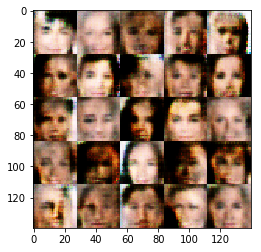

Training epoch 0 of 1 has:  Discriminator loss of 0.7917 and generator loss of 1.1905
Training epoch 0 of 1 has:  Discriminator loss of 1.7022 and generator loss of 0.5159
Training epoch 0 of 1 has:  Discriminator loss of 1.1574 and generator loss of 1.2628
Training epoch 0 of 1 has:  Discriminator loss of 1.5180 and generator loss of 0.6132
Training epoch 0 of 1 has:  Discriminator loss of 1.2836 and generator loss of 0.7943


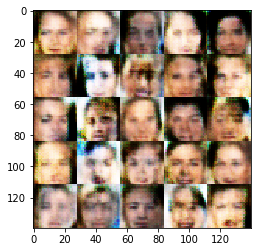

Training epoch 0 of 1 has:  Discriminator loss of 1.5446 and generator loss of 0.5876
Training epoch 0 of 1 has:  Discriminator loss of 1.0844 and generator loss of 0.6851
Training epoch 0 of 1 has:  Discriminator loss of 1.2281 and generator loss of 1.0476
Training epoch 0 of 1 has:  Discriminator loss of 0.7914 and generator loss of 1.1013
Training epoch 0 of 1 has:  Discriminator loss of 1.7743 and generator loss of 0.4915


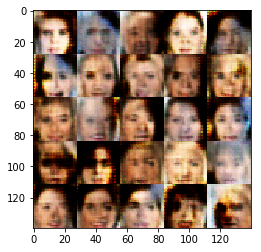

Training epoch 0 of 1 has:  Discriminator loss of 1.3321 and generator loss of 1.1668
Training epoch 0 of 1 has:  Discriminator loss of 1.2797 and generator loss of 0.9176
Training epoch 0 of 1 has:  Discriminator loss of 1.1943 and generator loss of 0.7834
Training epoch 0 of 1 has:  Discriminator loss of 0.7608 and generator loss of 1.2014
Training epoch 0 of 1 has:  Discriminator loss of 1.3105 and generator loss of 1.2953


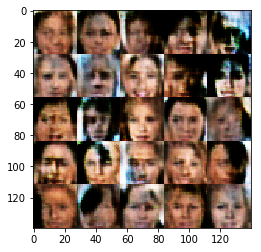

Training epoch 0 of 1 has:  Discriminator loss of 1.4526 and generator loss of 0.5418
Training epoch 0 of 1 has:  Discriminator loss of 1.3837 and generator loss of 0.7316
Training epoch 0 of 1 has:  Discriminator loss of 1.5141 and generator loss of 0.4913
Training epoch 0 of 1 has:  Discriminator loss of 1.3807 and generator loss of 0.8158
Training epoch 0 of 1 has:  Discriminator loss of 1.1899 and generator loss of 0.9152


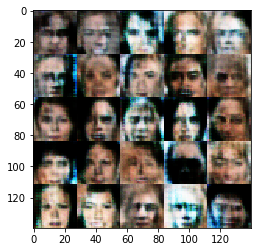

Training epoch 0 of 1 has:  Discriminator loss of 1.0683 and generator loss of 0.8658
Training epoch 0 of 1 has:  Discriminator loss of 1.4488 and generator loss of 2.0344
Training epoch 0 of 1 has:  Discriminator loss of 1.3046 and generator loss of 0.8370
Training epoch 0 of 1 has:  Discriminator loss of 1.2136 and generator loss of 0.6635
Training epoch 0 of 1 has:  Discriminator loss of 1.2175 and generator loss of 1.0173


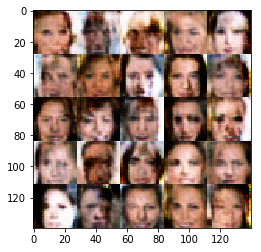

Training epoch 0 of 1 has:  Discriminator loss of 1.2204 and generator loss of 0.6602
Training epoch 0 of 1 has:  Discriminator loss of 1.0260 and generator loss of 0.9814
Training epoch 0 of 1 has:  Discriminator loss of 0.8787 and generator loss of 1.0018
Training epoch 0 of 1 has:  Discriminator loss of 1.5035 and generator loss of 0.6661
Training epoch 0 of 1 has:  Discriminator loss of 1.4258 and generator loss of 0.7508


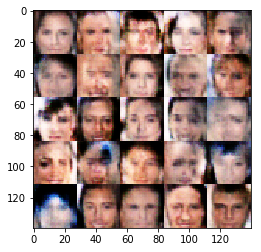

Training epoch 0 of 1 has:  Discriminator loss of 1.0887 and generator loss of 1.2331
Training epoch 0 of 1 has:  Discriminator loss of 1.3131 and generator loss of 1.2519
Training epoch 0 of 1 has:  Discriminator loss of 1.2893 and generator loss of 0.5674
Training epoch 0 of 1 has:  Discriminator loss of 1.2906 and generator loss of 0.5238
Training epoch 0 of 1 has:  Discriminator loss of 0.9990 and generator loss of 0.9522


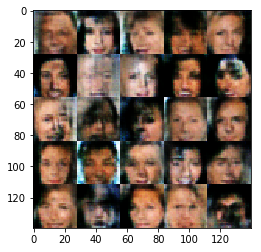

Training epoch 0 of 1 has:  Discriminator loss of 1.3164 and generator loss of 0.9451
Training epoch 0 of 1 has:  Discriminator loss of 1.3067 and generator loss of 0.5980
Training epoch 0 of 1 has:  Discriminator loss of 1.4493 and generator loss of 1.1708
Training epoch 0 of 1 has:  Discriminator loss of 1.3723 and generator loss of 0.8233
Training epoch 0 of 1 has:  Discriminator loss of 1.5296 and generator loss of 0.7459


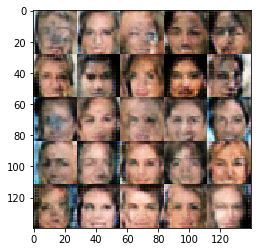

Training epoch 0 of 1 has:  Discriminator loss of 1.3412 and generator loss of 1.7027
Training epoch 0 of 1 has:  Discriminator loss of 1.0576 and generator loss of 0.9638
Training epoch 0 of 1 has:  Discriminator loss of 1.5525 and generator loss of 2.3566
Training epoch 0 of 1 has:  Discriminator loss of 1.5172 and generator loss of 0.5233
Training epoch 0 of 1 has:  Discriminator loss of 1.4017 and generator loss of 0.6050


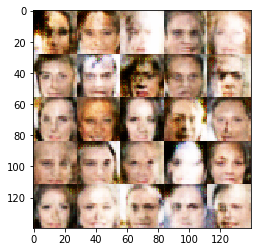

Training epoch 0 of 1 has:  Discriminator loss of 1.1701 and generator loss of 0.7998
Training epoch 0 of 1 has:  Discriminator loss of 1.3820 and generator loss of 0.5921
Training epoch 0 of 1 has:  Discriminator loss of 1.1995 and generator loss of 0.6359
Training epoch 0 of 1 has:  Discriminator loss of 1.3893 and generator loss of 0.8305
Training epoch 0 of 1 has:  Discriminator loss of 1.1616 and generator loss of 0.8003


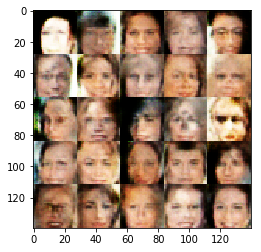

Training epoch 0 of 1 has:  Discriminator loss of 1.2896 and generator loss of 1.0119
Training epoch 0 of 1 has:  Discriminator loss of 1.2762 and generator loss of 0.7907
Training epoch 0 of 1 has:  Discriminator loss of 1.2276 and generator loss of 1.0196
Training epoch 0 of 1 has:  Discriminator loss of 1.2057 and generator loss of 0.9647
Training epoch 0 of 1 has:  Discriminator loss of 1.2581 and generator loss of 0.6153


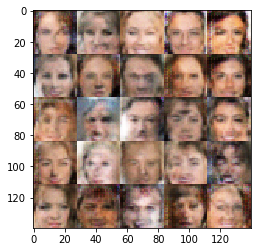

Training epoch 0 of 1 has:  Discriminator loss of 1.2840 and generator loss of 0.7550
Training epoch 0 of 1 has:  Discriminator loss of 1.3341 and generator loss of 0.5151
Training epoch 0 of 1 has:  Discriminator loss of 1.3892 and generator loss of 0.6630
Training epoch 0 of 1 has:  Discriminator loss of 1.1242 and generator loss of 1.1493
Training epoch 0 of 1 has:  Discriminator loss of 1.3034 and generator loss of 0.8017


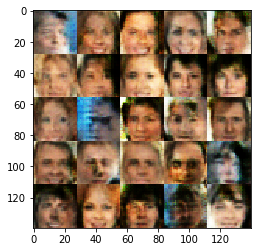

Training epoch 0 of 1 has:  Discriminator loss of 1.2640 and generator loss of 1.0508
Training epoch 0 of 1 has:  Discriminator loss of 1.0823 and generator loss of 0.8541
Training epoch 0 of 1 has:  Discriminator loss of 1.4559 and generator loss of 0.7356
Training epoch 0 of 1 has:  Discriminator loss of 1.3681 and generator loss of 0.9769
Training epoch 0 of 1 has:  Discriminator loss of 1.3123 and generator loss of 0.7771


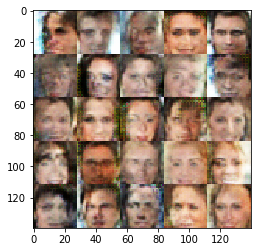

Training epoch 0 of 1 has:  Discriminator loss of 1.1684 and generator loss of 0.7615
Training epoch 0 of 1 has:  Discriminator loss of 1.1627 and generator loss of 0.8390
Training epoch 0 of 1 has:  Discriminator loss of 1.4435 and generator loss of 0.6745
Training epoch 0 of 1 has:  Discriminator loss of 1.1854 and generator loss of 1.1243
Training epoch 0 of 1 has:  Discriminator loss of 1.2428 and generator loss of 0.8473


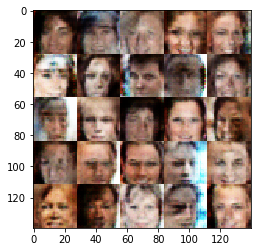

Training epoch 0 of 1 has:  Discriminator loss of 1.3095 and generator loss of 0.7030
Training epoch 0 of 1 has:  Discriminator loss of 1.4469 and generator loss of 0.7796
Training epoch 0 of 1 has:  Discriminator loss of 1.3311 and generator loss of 0.6154
Training epoch 0 of 1 has:  Discriminator loss of 1.2971 and generator loss of 0.5720
Training epoch 0 of 1 has:  Discriminator loss of 1.3125 and generator loss of 0.7389


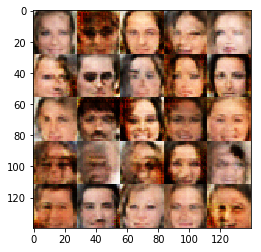

Training epoch 0 of 1 has:  Discriminator loss of 2.0871 and generator loss of 1.4881
Training epoch 0 of 1 has:  Discriminator loss of 1.2533 and generator loss of 0.8570
Training epoch 0 of 1 has:  Discriminator loss of 0.9723 and generator loss of 0.8154
Training epoch 0 of 1 has:  Discriminator loss of 2.3082 and generator loss of 0.1661
Training epoch 0 of 1 has:  Discriminator loss of 1.3611 and generator loss of 0.6280


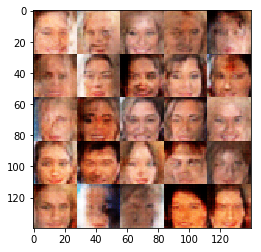

Training epoch 0 of 1 has:  Discriminator loss of 1.4574 and generator loss of 0.7782
Training epoch 0 of 1 has:  Discriminator loss of 1.1733 and generator loss of 0.7829
Training epoch 0 of 1 has:  Discriminator loss of 1.2584 and generator loss of 1.0557
Training epoch 0 of 1 has:  Discriminator loss of 1.4125 and generator loss of 0.8694
Training epoch 0 of 1 has:  Discriminator loss of 1.2378 and generator loss of 0.6669


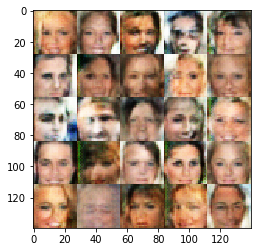

Training epoch 0 of 1 has:  Discriminator loss of 0.9869 and generator loss of 0.9630
Training epoch 0 of 1 has:  Discriminator loss of 2.0657 and generator loss of 0.2254
Training epoch 0 of 1 has:  Discriminator loss of 1.0034 and generator loss of 0.8703
Training epoch 0 of 1 has:  Discriminator loss of 1.2834 and generator loss of 0.7030
Training epoch 0 of 1 has:  Discriminator loss of 1.3385 and generator loss of 0.7912


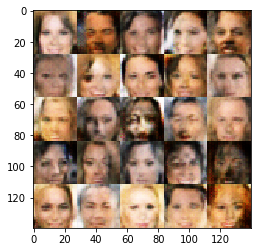

Training epoch 0 of 1 has:  Discriminator loss of 1.1191 and generator loss of 0.7736
Training epoch 0 of 1 has:  Discriminator loss of 1.5448 and generator loss of 0.5022
Training epoch 0 of 1 has:  Discriminator loss of 1.1832 and generator loss of 0.7123
Training epoch 0 of 1 has:  Discriminator loss of 1.3151 and generator loss of 0.6772
Training epoch 0 of 1 has:  Discriminator loss of 1.4155 and generator loss of 0.5676


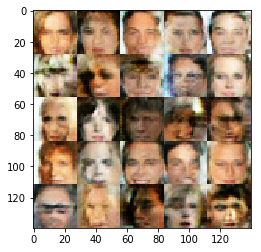

Training epoch 0 of 1 has:  Discriminator loss of 1.2831 and generator loss of 0.7393
Training epoch 0 of 1 has:  Discriminator loss of 1.2174 and generator loss of 0.6613
Training epoch 0 of 1 has:  Discriminator loss of 1.0172 and generator loss of 0.8985
Training epoch 0 of 1 has:  Discriminator loss of 1.3112 and generator loss of 0.8644
Training epoch 0 of 1 has:  Discriminator loss of 1.3336 and generator loss of 0.6090


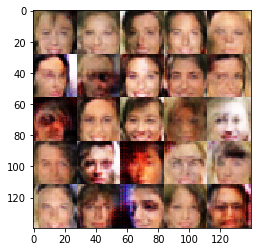

Training epoch 0 of 1 has:  Discriminator loss of 1.5435 and generator loss of 0.5998
Training epoch 0 of 1 has:  Discriminator loss of 1.2689 and generator loss of 0.7603
Training epoch 0 of 1 has:  Discriminator loss of 1.3059 and generator loss of 0.7531
Training epoch 0 of 1 has:  Discriminator loss of 1.5769 and generator loss of 0.3778
Training epoch 0 of 1 has:  Discriminator loss of 1.2096 and generator loss of 1.2364


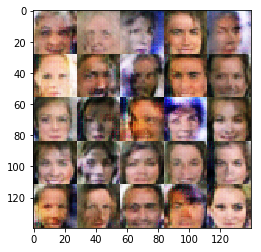

Training epoch 0 of 1 has:  Discriminator loss of 1.2731 and generator loss of 0.8804
Training epoch 0 of 1 has:  Discriminator loss of 1.9877 and generator loss of 0.2820
Training epoch 0 of 1 has:  Discriminator loss of 1.2363 and generator loss of 0.7787
Training epoch 0 of 1 has:  Discriminator loss of 2.5616 and generator loss of 0.1476
Training epoch 0 of 1 has:  Discriminator loss of 1.2638 and generator loss of 0.8911


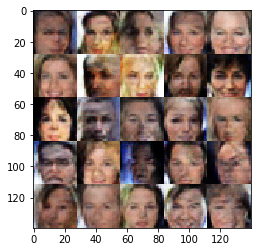

Training epoch 0 of 1 has:  Discriminator loss of 1.1960 and generator loss of 1.0981
Training epoch 0 of 1 has:  Discriminator loss of 1.2872 and generator loss of 0.8490
Training epoch 0 of 1 has:  Discriminator loss of 1.4396 and generator loss of 0.7145
Training epoch 0 of 1 has:  Discriminator loss of 1.2065 and generator loss of 0.7762
Training epoch 0 of 1 has:  Discriminator loss of 1.1943 and generator loss of 0.6773


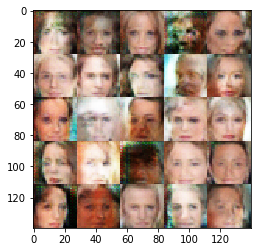

Training epoch 0 of 1 has:  Discriminator loss of 0.9771 and generator loss of 0.9762
Training epoch 0 of 1 has:  Discriminator loss of 1.4136 and generator loss of 0.5391
Training epoch 0 of 1 has:  Discriminator loss of 1.1224 and generator loss of 0.9987
Training epoch 0 of 1 has:  Discriminator loss of 1.6899 and generator loss of 0.4826
Training epoch 0 of 1 has:  Discriminator loss of 1.2096 and generator loss of 0.6997


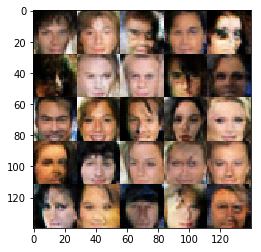

Training epoch 0 of 1 has:  Discriminator loss of 1.3902 and generator loss of 0.6354
Training epoch 0 of 1 has:  Discriminator loss of 1.2765 and generator loss of 0.9865
Training epoch 0 of 1 has:  Discriminator loss of 1.3127 and generator loss of 0.8536
Training epoch 0 of 1 has:  Discriminator loss of 1.1207 and generator loss of 0.6410
Training epoch 0 of 1 has:  Discriminator loss of 1.1880 and generator loss of 0.8654


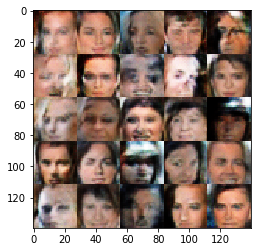

Training epoch 0 of 1 has:  Discriminator loss of 1.1428 and generator loss of 0.6225
Training epoch 0 of 1 has:  Discriminator loss of 1.5179 and generator loss of 0.6834
Training epoch 0 of 1 has:  Discriminator loss of 1.5823 and generator loss of 0.4409
Training epoch 0 of 1 has:  Discriminator loss of 1.1975 and generator loss of 0.8325
Training epoch 0 of 1 has:  Discriminator loss of 1.7858 and generator loss of 0.3766


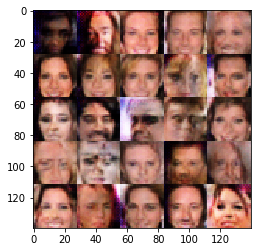

Training epoch 0 of 1 has:  Discriminator loss of 1.3268 and generator loss of 0.6578
Training epoch 0 of 1 has:  Discriminator loss of 1.5614 and generator loss of 1.1328
Training epoch 0 of 1 has:  Discriminator loss of 1.3036 and generator loss of 0.7788
Training epoch 0 of 1 has:  Discriminator loss of 1.2604 and generator loss of 0.7757
Training epoch 0 of 1 has:  Discriminator loss of 1.2705 and generator loss of 0.8858


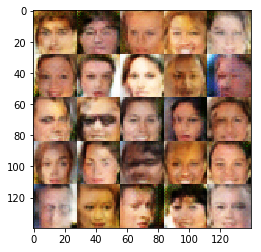

Training epoch 0 of 1 has:  Discriminator loss of 1.2091 and generator loss of 0.5808
Training epoch 0 of 1 has:  Discriminator loss of 1.2411 and generator loss of 0.6784
Training epoch 0 of 1 has:  Discriminator loss of 1.7007 and generator loss of 0.3729
Training epoch 0 of 1 has:  Discriminator loss of 1.3374 and generator loss of 0.5249
Training epoch 0 of 1 has:  Discriminator loss of 1.1480 and generator loss of 1.2106


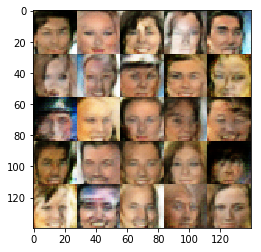

Training epoch 0 of 1 has:  Discriminator loss of 1.2972 and generator loss of 0.8949
Training epoch 0 of 1 has:  Discriminator loss of 1.9148 and generator loss of 0.3082
Training epoch 0 of 1 has:  Discriminator loss of 1.3424 and generator loss of 0.6720
Training epoch 0 of 1 has:  Discriminator loss of 1.9625 and generator loss of 0.2926
Training epoch 0 of 1 has:  Discriminator loss of 1.0686 and generator loss of 0.9541


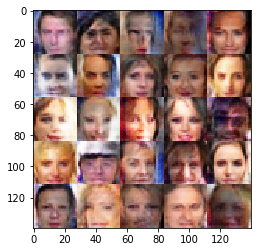

Training epoch 0 of 1 has:  Discriminator loss of 1.3651 and generator loss of 0.6494
Training epoch 0 of 1 has:  Discriminator loss of 1.4196 and generator loss of 0.4678
Training epoch 0 of 1 has:  Discriminator loss of 1.5106 and generator loss of 0.5848
Training epoch 0 of 1 has:  Discriminator loss of 1.4206 and generator loss of 0.4804
Training epoch 0 of 1 has:  Discriminator loss of 1.1071 and generator loss of 0.7929


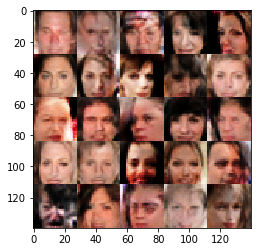

Training epoch 0 of 1 has:  Discriminator loss of 0.9747 and generator loss of 1.1652
Training epoch 0 of 1 has:  Discriminator loss of 1.2247 and generator loss of 1.2374
Training epoch 0 of 1 has:  Discriminator loss of 0.9475 and generator loss of 0.8571
Training epoch 0 of 1 has:  Discriminator loss of 1.2278 and generator loss of 0.6392
Training epoch 0 of 1 has:  Discriminator loss of 1.0200 and generator loss of 0.9534


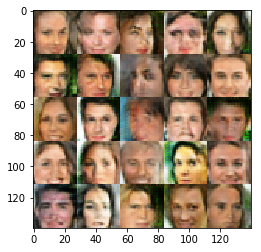

Training epoch 0 of 1 has:  Discriminator loss of 1.2928 and generator loss of 0.8833
Training epoch 0 of 1 has:  Discriminator loss of 1.2295 and generator loss of 0.8808
Training epoch 0 of 1 has:  Discriminator loss of 1.1900 and generator loss of 0.5871
Training epoch 0 of 1 has:  Discriminator loss of 1.3693 and generator loss of 0.5426
Training epoch 0 of 1 has:  Discriminator loss of 1.3628 and generator loss of 0.6669


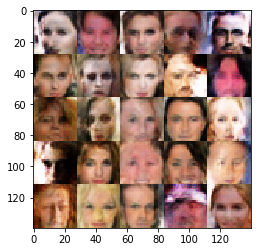

Training epoch 0 of 1 has:  Discriminator loss of 1.2378 and generator loss of 0.8953
Training epoch 0 of 1 has:  Discriminator loss of 1.3456 and generator loss of 0.7248
Training epoch 0 of 1 has:  Discriminator loss of 1.2350 and generator loss of 0.6045
Training epoch 0 of 1 has:  Discriminator loss of 1.2011 and generator loss of 0.6962
Training epoch 0 of 1 has:  Discriminator loss of 1.5196 and generator loss of 0.5773


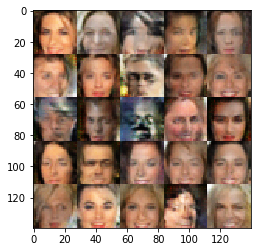

Training epoch 0 of 1 has:  Discriminator loss of 1.3168 and generator loss of 0.6239
Training epoch 0 of 1 has:  Discriminator loss of 1.3836 and generator loss of 0.5868
Training epoch 0 of 1 has:  Discriminator loss of 1.3265 and generator loss of 0.6764
Training epoch 0 of 1 has:  Discriminator loss of 1.3628 and generator loss of 0.5679
Training epoch 0 of 1 has:  Discriminator loss of 1.3034 and generator loss of 0.6689


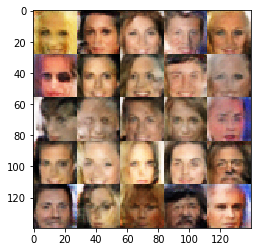

Training epoch 0 of 1 has:  Discriminator loss of 1.3218 and generator loss of 0.5867
Training epoch 0 of 1 has:  Discriminator loss of 1.3995 and generator loss of 0.5348
Training epoch 0 of 1 has:  Discriminator loss of 1.5114 and generator loss of 0.5680
Training epoch 0 of 1 has:  Discriminator loss of 1.1905 and generator loss of 0.8357
Training epoch 0 of 1 has:  Discriminator loss of 1.2889 and generator loss of 0.7966


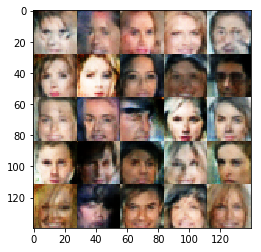

Training epoch 0 of 1 has:  Discriminator loss of 1.2860 and generator loss of 0.9586
Training epoch 0 of 1 has:  Discriminator loss of 1.2870 and generator loss of 0.8657
Training epoch 0 of 1 has:  Discriminator loss of 1.2600 and generator loss of 0.7011
Training epoch 0 of 1 has:  Discriminator loss of 1.1845 and generator loss of 0.9510
Training epoch 0 of 1 has:  Discriminator loss of 1.3456 and generator loss of 0.5566


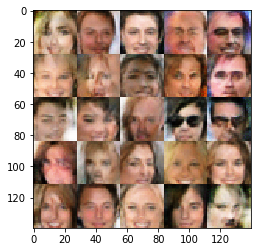

Training epoch 0 of 1 has:  Discriminator loss of 1.3310 and generator loss of 0.7975
Training epoch 0 of 1 has:  Discriminator loss of 1.2552 and generator loss of 0.7251
Training epoch 0 of 1 has:  Discriminator loss of 1.1291 and generator loss of 0.7131
Training epoch 0 of 1 has:  Discriminator loss of 1.4073 and generator loss of 0.7290
Training epoch 0 of 1 has:  Discriminator loss of 1.2805 and generator loss of 0.7122


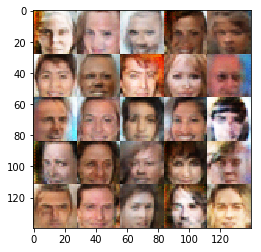

Training epoch 0 of 1 has:  Discriminator loss of 1.2133 and generator loss of 0.8209
Training epoch 0 of 1 has:  Discriminator loss of 1.3627 and generator loss of 0.6891
Training epoch 0 of 1 has:  Discriminator loss of 1.1860 and generator loss of 0.8628
Training epoch 0 of 1 has:  Discriminator loss of 1.2706 and generator loss of 0.6682
Training epoch 0 of 1 has:  Discriminator loss of 1.2942 and generator loss of 0.5697


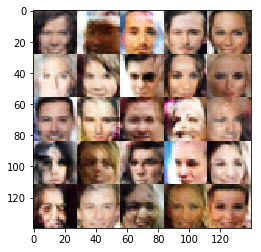

Training epoch 0 of 1 has:  Discriminator loss of 1.2870 and generator loss of 0.8732
Training epoch 0 of 1 has:  Discriminator loss of 1.4436 and generator loss of 0.5881
Training epoch 0 of 1 has:  Discriminator loss of 1.2967 and generator loss of 0.5628
Training epoch 0 of 1 has:  Discriminator loss of 1.4016 and generator loss of 0.7363
Training epoch 0 of 1 has:  Discriminator loss of 1.4313 and generator loss of 0.5284


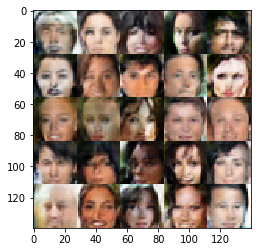

Training epoch 0 of 1 has:  Discriminator loss of 1.3461 and generator loss of 0.7419
Training epoch 0 of 1 has:  Discriminator loss of 1.3031 and generator loss of 0.9953
Training epoch 0 of 1 has:  Discriminator loss of 1.1637 and generator loss of 0.8135
Training epoch 0 of 1 has:  Discriminator loss of 1.3663 and generator loss of 1.0478
Training epoch 0 of 1 has:  Discriminator loss of 1.3048 and generator loss of 1.0132


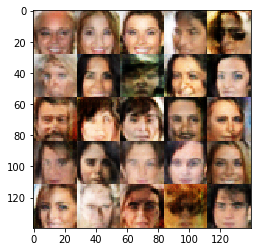

Training epoch 0 of 1 has:  Discriminator loss of 1.2747 and generator loss of 0.9238
Training epoch 0 of 1 has:  Discriminator loss of 1.2039 and generator loss of 1.0940
Training epoch 0 of 1 has:  Discriminator loss of 1.1513 and generator loss of 0.6887
Training epoch 0 of 1 has:  Discriminator loss of 1.3293 and generator loss of 0.5873
Training epoch 0 of 1 has:  Discriminator loss of 1.1600 and generator loss of 0.7221


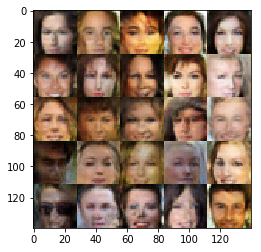

Training epoch 0 of 1 has:  Discriminator loss of 1.3781 and generator loss of 0.7835
Training epoch 0 of 1 has:  Discriminator loss of 1.3029 and generator loss of 0.9261
Training epoch 0 of 1 has:  Discriminator loss of 1.1366 and generator loss of 0.6941
Training epoch 0 of 1 has:  Discriminator loss of 1.2483 and generator loss of 0.9230
Training epoch 0 of 1 has:  Discriminator loss of 1.0449 and generator loss of 0.7208


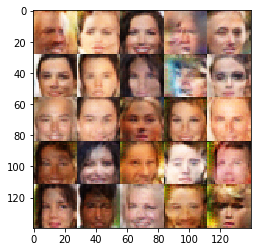

Training epoch 0 of 1 has:  Discriminator loss of 1.2176 and generator loss of 0.8724
Training epoch 0 of 1 has:  Discriminator loss of 1.2192 and generator loss of 0.9018
Training epoch 0 of 1 has:  Discriminator loss of 1.4866 and generator loss of 0.5382
Training epoch 0 of 1 has:  Discriminator loss of 1.4413 and generator loss of 0.4967
Training epoch 0 of 1 has:  Discriminator loss of 1.6603 and generator loss of 0.5340


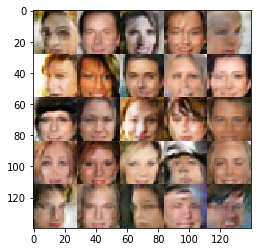

Training epoch 0 of 1 has:  Discriminator loss of 1.2166 and generator loss of 0.7826
Training epoch 0 of 1 has:  Discriminator loss of 1.4324 and generator loss of 0.8821
Training epoch 0 of 1 has:  Discriminator loss of 1.4400 and generator loss of 0.8779
Training epoch 0 of 1 has:  Discriminator loss of 1.2983 and generator loss of 0.7101
Training epoch 0 of 1 has:  Discriminator loss of 1.3514 and generator loss of 0.5447


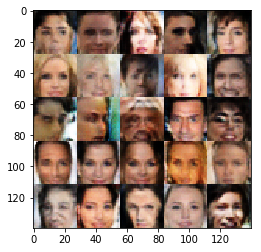

Training epoch 0 of 1 has:  Discriminator loss of 1.2851 and generator loss of 0.5415
Training epoch 0 of 1 has:  Discriminator loss of 1.4450 and generator loss of 0.4224
Training epoch 0 of 1 has:  Discriminator loss of 1.4600 and generator loss of 0.8383
Training epoch 0 of 1 has:  Discriminator loss of 1.4504 and generator loss of 0.6670
Training epoch 0 of 1 has:  Discriminator loss of 1.1050 and generator loss of 0.6791


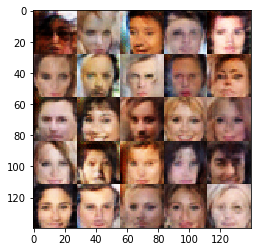

Training epoch 0 of 1 has:  Discriminator loss of 1.2718 and generator loss of 0.6172
Training epoch 0 of 1 has:  Discriminator loss of 1.2658 and generator loss of 0.5987
Training epoch 0 of 1 has:  Discriminator loss of 1.3745 and generator loss of 0.6439
Training epoch 0 of 1 has:  Discriminator loss of 1.2512 and generator loss of 0.6618
Training epoch 0 of 1 has:  Discriminator loss of 1.5349 and generator loss of 0.5957


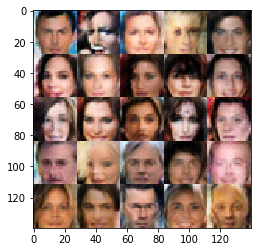

Training epoch 0 of 1 has:  Discriminator loss of 1.4572 and generator loss of 0.5756
Training epoch 0 of 1 has:  Discriminator loss of 1.3029 and generator loss of 0.7622
Training epoch 0 of 1 has:  Discriminator loss of 1.2604 and generator loss of 0.9390
Training epoch 0 of 1 has:  Discriminator loss of 1.3777 and generator loss of 0.5505
Training epoch 0 of 1 has:  Discriminator loss of 1.3870 and generator loss of 0.5752


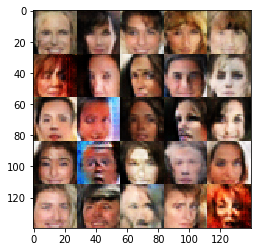

Training epoch 0 of 1 has:  Discriminator loss of 1.4444 and generator loss of 0.6553
Training epoch 0 of 1 has:  Discriminator loss of 1.1093 and generator loss of 0.7483
Training epoch 0 of 1 has:  Discriminator loss of 1.4520 and generator loss of 0.6970
Training epoch 0 of 1 has:  Discriminator loss of 1.1527 and generator loss of 0.7342
Training epoch 0 of 1 has:  Discriminator loss of 1.3056 and generator loss of 0.7108


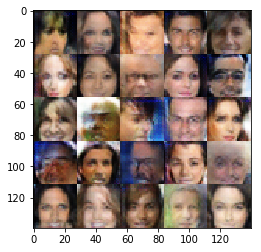

Training epoch 0 of 1 has:  Discriminator loss of 1.3216 and generator loss of 0.8187
Training epoch 0 of 1 has:  Discriminator loss of 1.5873 and generator loss of 0.4998
Training epoch 0 of 1 has:  Discriminator loss of 1.2422 and generator loss of 0.7976
Training epoch 0 of 1 has:  Discriminator loss of 1.3855 and generator loss of 0.8795
Training epoch 0 of 1 has:  Discriminator loss of 1.2974 and generator loss of 0.8717


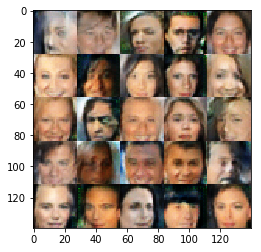

Training epoch 0 of 1 has:  Discriminator loss of 1.4061 and generator loss of 0.5112
Training epoch 0 of 1 has:  Discriminator loss of 1.3998 and generator loss of 0.7741
Training epoch 0 of 1 has:  Discriminator loss of 1.5259 and generator loss of 0.7126
Training epoch 0 of 1 has:  Discriminator loss of 1.1102 and generator loss of 0.7240
Training epoch 0 of 1 has:  Discriminator loss of 1.1850 and generator loss of 0.6381


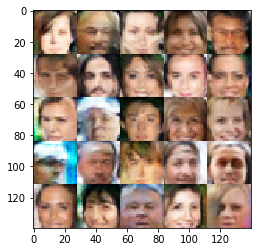

Training epoch 0 of 1 has:  Discriminator loss of 1.3610 and generator loss of 0.5961
Training epoch 0 of 1 has:  Discriminator loss of 1.2082 and generator loss of 0.6478
Training epoch 0 of 1 has:  Discriminator loss of 1.4203 and generator loss of 0.6874
Training epoch 0 of 1 has:  Discriminator loss of 1.2575 and generator loss of 0.6608
Training epoch 0 of 1 has:  Discriminator loss of 1.4003 and generator loss of 0.6824


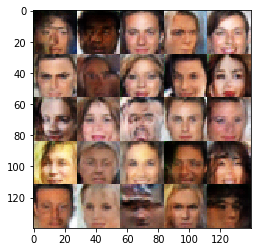

Training epoch 0 of 1 has:  Discriminator loss of 1.3706 and generator loss of 0.7228
Training epoch 0 of 1 has:  Discriminator loss of 1.3799 and generator loss of 0.8050
Training epoch 0 of 1 has:  Discriminator loss of 1.3187 and generator loss of 0.6423


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0008
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.